In [9]:
#read data
import pandas as pd
file_path = '/content/complete_classified_resumes.csv'
df = pd.read_csv(file_path)

df.head()

,name,email,phone,links,role,skills,education,experience_years,summary,match_score
0,Zane Clark,ymyeliyi@email.com,+1 0729651222,https://linkedin.com/in/jskknimopu; https://gi...,Data Journalist,tableau; power bi; r; scikit-learn; excel; mac...,Bachelor of Science in Data Management,14.0,A dedicated and results-driven Data Journalist...,4.166667
1,Penelope Young,frgfpacq@email.com,+1 8121057943,https://linkedin.com/in/wvohfjcbgm; https://gi...,Fraud Analyst,tableau; power bi; r; numpy; scikit-learn; exc...,Master of Science in Quantitative Finance,14.0,A dedicated and results-driven Fraud Analyst w...,4.166667
2,Zach Lee,tuobnixp@email.com,+1 8690904865,https://linkedin.com/in/trxzrapnqj; https://gi...,Data Analyst,sql; tableau; power bi; r; machine learning; s...,Bachelor of Science in Economics and Data Science,10.0,A dedicated and results-driven Healthcare Data...,5.833333
3,Liam Carter,wvtixbwk@email.com,+1 4517200462,https://linkedin.com/in/ytsvtwokny; https://gi...,Bi Developer,sql; tableau; power bi; r; pandas; machine lea...,Master of Engineering in Data Engineering,4.0,A dedicated and results-driven BI Developer wi...,5.833333
4,Henry Hill,iwvoyjov@email.com,+1 4516660758,https://linkedin.com/in/tabgyhvjll; https://gi...,Data Scientist,tableau; power bi; r; excel; java; machine lea...,Bachelor of Engineering in AI and ML,6.0,A dedicated and results-driven Sports Data Sci...,4.166667


In [10]:
#Data preprocessing
import numpy as np
from sklearn.preprocessing import LabelEncoder

df_clean = df.copy()

# Fill missing 'education'
df_clean["education"].fillna("Unknown", inplace=True)
# Drop rows with missing 'email'
df_clean.dropna(subset=["email"], inplace=True)

# Normalize Text Columns
text_columns = ["skills", "education", "summary", "role"] #only process these row because they are important
for col in text_columns:
    df_clean[col] = df_clean[col].str.lower().str.strip()


df_clean.info(), df_clean.head()


<class 'pandas.core.frame.DataFrame'>
Index: 998 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              998 non-null    object 
 1   email             998 non-null    object 
 2   phone             998 non-null    object 
 3   links             998 non-null    object 
 4   role              998 non-null    object 
 5   skills            998 non-null    object 
 6   education         998 non-null    object 
 7   experience_years  998 non-null    float64
 8   summary           998 non-null    object 
 9   match_score       998 non-null    float64
dtypes: float64(2), object(8)
memory usage: 85.8+ KB


<ipython-input-10-3df425ac9496>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean["education"].fillna("Unknown", inplace=True)


(None,
              name               email          phone  \
 0      Zane Clark  ymyeliyi@email.com  +1 0729651222   
 1  Penelope Young  frgfpacq@email.com  +1 8121057943   
 2        Zach Lee  tuobnixp@email.com  +1 8690904865   
 3     Liam Carter  wvtixbwk@email.com  +1 4517200462   
 4      Henry Hill  iwvoyjov@email.com  +1 4516660758   
 
                                                links             role  \
 0  https://linkedin.com/in/jskknimopu; https://gi...  data journalist   
 1  https://linkedin.com/in/wvohfjcbgm; https://gi...    fraud analyst   
 2  https://linkedin.com/in/trxzrapnqj; https://gi...     data analyst   
 3  https://linkedin.com/in/ytsvtwokny; https://gi...     bi developer   
 4  https://linkedin.com/in/tabgyhvjll; https://gi...   data scientist   
 
                                               skills  \
 0  tableau; power bi; r; scikit-learn; excel; mac...   
 1  tableau; power bi; r; numpy; scikit-learn; exc...   
 2  sql; tableau; power bi; r; m

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

# --- Step 1: TF-IDF Vectorization for Text Columns ---
# Limit vocabulary size to reduce dimensionality
tfidf_role = TfidfVectorizer(max_features=20)
tfidf_skills = TfidfVectorizer(tokenizer=lambda x: x.split(';'), max_features=100)
tfidf_summary = TfidfVectorizer(max_features=100)

X_role = tfidf_role.fit_transform(df_clean["role"])
X_skills = tfidf_skills.fit_transform(df_clean["skills"])
X_summary = tfidf_summary.fit_transform(df_clean["summary"])

# --- Step 2: Scale Numeric Column ---
scaler = StandardScaler()
X_experience = scaler.fit_transform(df_clean[["experience_years"]])

# --- Step 3: Combine Features ---
X_combined = hstack([X_role, X_skills, X_summary, X_experience])
y = df_clean["match_score"]

# --- Step 4: Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# Output shapes for verification
X_combined.shape, X_train.shape, X_test.shape


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


((998, 172), (798, 172), (200, 172))

In [12]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Train XGBoost Regressor
xgb_reg = XGBRegressor(n_estimators=30, max_depth=4, learning_rate=0.1, random_state=42)
xgb_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

rmse, mae


(np.float64(0.042566379974898566), 0.039297068913777766)

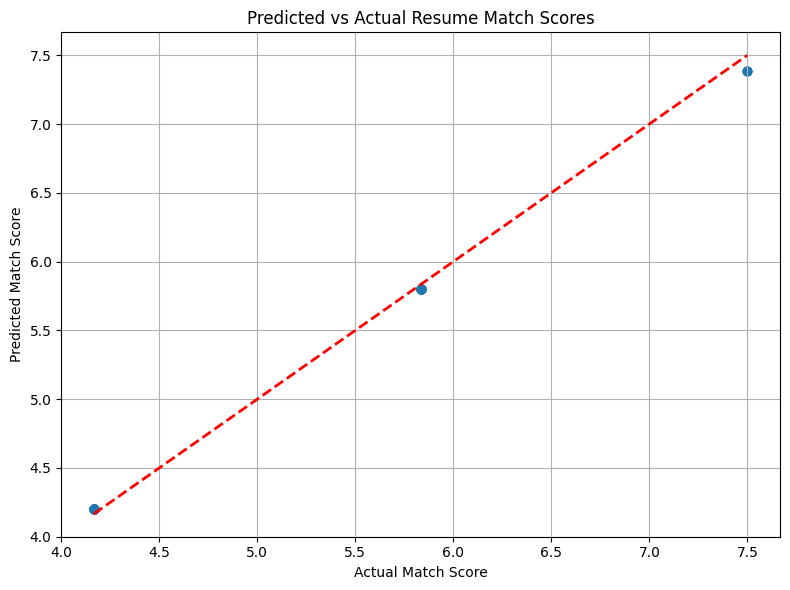

In [13]:
# Plot predicted vs actual match scores
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Match Score")
plt.ylabel("Predicted Match Score")
plt.title("Predicted vs Actual Resume Match Scores")
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
#test
import random

# Helper to generate synthetic resume based on dataset patterns
job_requirements = {
    "required_skills": ["sql", "python", "tableau"],
    "preferred_skills": ["aws athena", "snowflake", "git", "jira", "confluence", "agile", "scrum"],
    "education_fields": ["statistics", "mathematics", "quantitative analysis", "computer science", "information technology"],
    "min_experience_years": 3,
    "soft_skills_keywords": ["communication", "english", "problem-solving", "cross-functional", "client-facing"],
}
def generate_synthetic_resume():
    sample_row = df.sample(1).iloc[0]

    # Mix and match existing skills
    skills_pool = list(set(";".join(df["skills"].tolist()).split(";")))
    random.shuffle(skills_pool)
    new_skills = "; ".join(skills_pool[:random.randint(4, 8)])

    # Generate synthetic summary using soft skills and buzzwords
    soft_keywords = job_requirements['soft_skills_keywords']
    buzzwords = ["team player", "detail-oriented", "self-motivated", "data-driven", "critical thinker"]
    summary_keywords = random.sample(soft_keywords + buzzwords, 4)
    new_summary = f"A {random.choice(['dedicated', 'experienced', 'motivated'])} data professional with strong {', '.join(summary_keywords)} skills."

    # Role sampling
    common_roles = df["role"].value_counts().head(10).index.tolist()
    new_role = random.choice(common_roles)

    # Experience
    new_exp = round(random.uniform(1, 10), 1)

    return {
        "role": new_role,
        "skills": new_skills.lower(),
        "summary": new_summary.lower(),
        "experience_years": new_exp
    }

# Generate 3 synthetic resumes
synthetic_resumes = [generate_synthetic_resume() for _ in range(3)]
pd.DataFrame(synthetic_resumes)


,role,skills,summary,experience_years
0,Data Strategist,sql; postgresql; kubernetes; sql; etl pipe...,a motivated data professional with strong engl...,2.4
1,Data Scientist,etl pipelines; data mining; pandas; plotly...,a dedicated data professional with strong prob...,9.3
2,Data Analyst,data wrangling; etl pipelines; mlops; kube...,a motivated data professional with strong team...,1.4


In [17]:
from scipy.sparse import csr_matrix

# Preprocess the synthetic resumes and predict scores using the trained model
def preprocess_and_predict(resumes):
    roles = tfidf_role.transform([r["role"] for r in resumes])
    skills = tfidf_skills.transform([r["skills"] for r in resumes])
    summaries = tfidf_summary.transform([r["summary"] for r in resumes])
    exp_years = scaler.transform([[r["experience_years"]] for r in resumes])

    # Combine into single feature matrix
    X_synthetic = hstack([roles, skills, summaries, exp_years])
    preds = xgb_reg.predict(X_synthetic)
    return preds

# Run prediction
predicted_scores = preprocess_and_predict(synthetic_resumes)

# Combine with synthetic resumes for display
df_synthetic_results = pd.DataFrame(synthetic_resumes)
df_synthetic_results["predicted_match_score"] = predicted_scores.round(2)

print(df_synthetic_results)


              role                                             skills  \
0  Data Strategist   sql;  postgresql;  kubernetes; sql;  etl pipe...   
1   Data Scientist   etl pipelines;  data mining;  pandas;  plotly...   
2     Data Analyst   data wrangling;  etl pipelines;  mlops;  kube...   

                                             summary  experience_years  \
0  a motivated data professional with strong engl...               2.4   
1  a dedicated data professional with strong prob...               9.3   
2  a motivated data professional with strong team...               1.4   

   predicted_match_score  
0                    4.2  
1                    4.2  
2                    4.2  


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
